# Objetivo

Esse notebook é uma continuação do anterior.<br>
O seu principal objetivo é identificar os principais motivadores para a saída de funcionários.

# O que pode levar um funcionário a sair da empresa?

## Baixa remuneração e falta de benefícios
    - MonthlyIncome
    - PercentSalaryHike
    - StockOptionLevel

## Qualidade de vida
    - BusinessTravel
    - DistanceFromHome
    - OverTime
    - WorkLifeBalance

## Satisfação (colegas, liderença, satisfação em geral, política de promoção)
    - EnvironmentSatisfaction
    - RelationshipSatisfaction
    - JobInvolvement
    - JobSatisfaction
    - YearsWithCurrManager

## Falta de desenvolvimento
    - TrainingTimesLastYear
    - YearsSinceLastPromotion
    
## Histórico profissional (ex: perfil de alta rotatividade)
    - YearsAtCompany
    - NumCompaniesWorked
    
**Obs: Categorias não MECE!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime

from plotting import plot_scatterplot
from plotting import plot_cohort
from plotting import plot_heatmap
from plotting import merge_quantiles


pd.set_option('max_rows', 250)
pd.set_option('max_columns', 50)
pd.set_option("display.precision", 3)

In [2]:
df = pd.read_excel('../Zup Test/data/HR.xlsx')
## Drop useless columns
df.drop(["EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"], axis=1, inplace=True)
# Fix Attrition and OverTime
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})
df["OverTime"] = df["OverTime"].map({'Yes': 1, 'No': 0})

print(df.shape)
df.head(3)

(1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0


# Overview

No notebook passado vimos que os departamentos de Sales e de Human Resources apresentam as maiores taxas de turnover.<br>
Além disso, vimos que algumas posições possuem uma alta taxa de rotatividade (ex: Sales Representative, Laboratory Technician, Human Resources)

<Figure size 432x288 with 0 Axes>

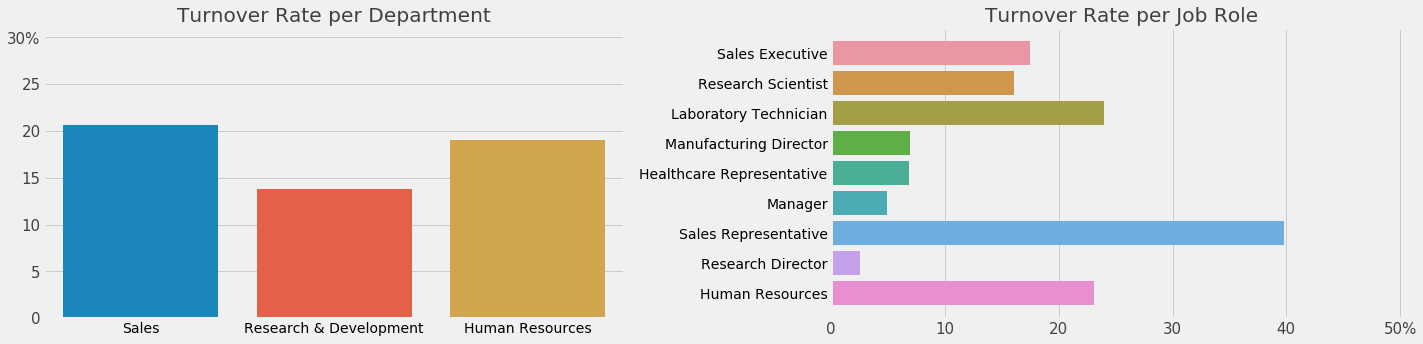

In [3]:
plt.clf()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,5))

#####################################################
#####################################################
    
plt.subplot(121)

ax = sns.barplot(x="Department", y="Attrition", data=df, ci=None)
plt.title("Turnover Rate per Department", color='#414141')
plt.xlabel("")
plt.ylabel("")

plt.ylim(0,0.31)
ax.set_yticklabels(labels=['0', '5', '10', '15', '20', '25', '30%'], fontsize=15, color='#414141')

#####################################################
#####################################################

plt.subplot(122)

ax = sns.barplot(x="Attrition", y="JobRole", data=df, ci=None)
plt.title("Turnover Rate per Job Role", color='#414141')
plt.xlabel("")
plt.ylabel("")

plt.xlim(0,0.51)
ax.set_xticklabels(labels=['0', '10', '20', '30', '40', '50%'], fontsize=15, color='#414141')


plt.tight_layout()
plt.plot();

Em busca do 20/80...

In [4]:
attrition_per_job = (
    df
    .groupby(["JobRole"])
    .agg(
        Churned=("Attrition", "sum"),
        Count=("Attrition", "count"),
        OverTime=("OverTime", "sum")
    )
    .reset_index()
)
attrition_per_job["dummy"] = 1
attrition_per_job["TurnoverRate"] = (attrition_per_job["Churned"] * 100 / attrition_per_job["Count"]).astype(int)
attrition_per_job = attrition_per_job.sort_values(by=["Churned"], ascending=False)
attrition_per_job["CumulativeAttrition"] = attrition_per_job["Churned"].cumsum() / attrition_per_job["Churned"].sum()*100
attrition_per_job["CumulativeJob"] = attrition_per_job["dummy"].cumsum() / attrition_per_job["dummy"].sum()*100
attrition_per_job["CumulativeOvertime"] = attrition_per_job["OverTime"].cumsum() / attrition_per_job["OverTime"].sum()*100

<Figure size 432x288 with 0 Axes>

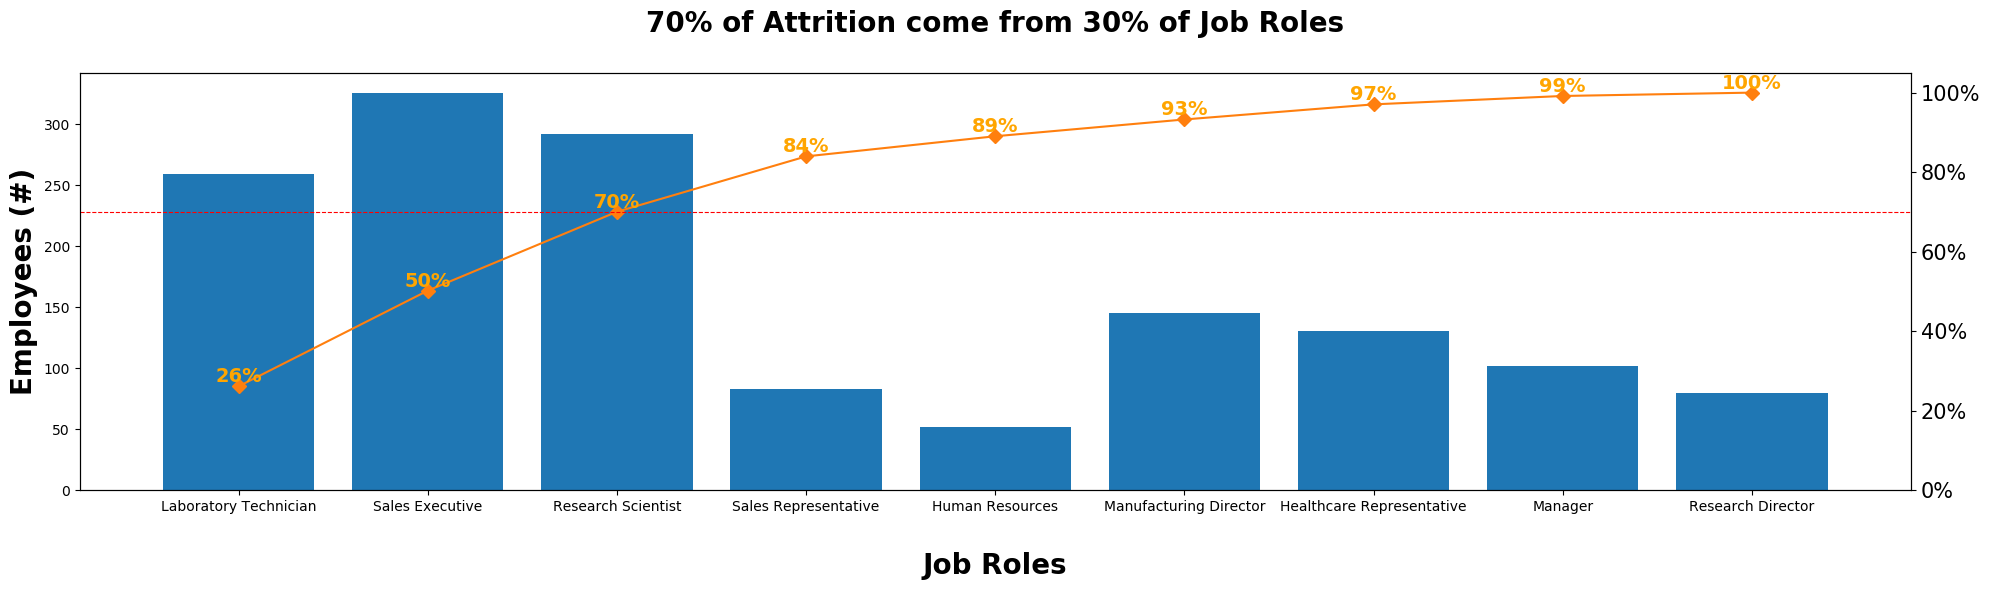

In [5]:
plt.clf()
plt.style.use('default')
fig, ax = plt.subplots(figsize=(20, 6))
font_opts = {"fontsize":20, "fontweight":"bold"}

#####################################################
#####################################################

X = attrition_per_job["JobRole"]
Y = attrition_per_job["Count"]

ax.bar(X, Y, color="C0")
ax.set_title("70% of Attrition come from 30% of Job Roles\n", **font_opts)
ax.set_xlabel("\nJob Roles", **font_opts)
ax.set_ylabel("Employees (#)", **font_opts)

# Plot Pareto's
ax1 = ax.twinx()
ax1.plot(X, attrition_per_job["CumulativeAttrition"], color="C1", marker="D", ms=7)
plt.tick_params(labelsize=11)
ax1.yaxis.set_major_formatter(PercentFormatter())
ax1.tick_params(labelsize=15)
ax1.set_ylim([0, 105])
ax1.set_yticks(np.arange(0, 101, 20))

# Add text info
for index, row in attrition_per_job.iterrows():
    ax1.text(x=row["JobRole"], y=row["CumulativeAttrition"], 
            s =str("{0:.0f}".format(row["CumulativeAttrition"])) + "%",
            ha="center", va='bottom', fontdict={"fontsize":14, "fontweight":"bold"}, color='orange')
# Plot line
plt.axhline(y=70, color="red", linewidth=0.8, linestyle='--') 

plt.tight_layout()
plt.plot();

Antes de darmos um Deep Dive tentarei entender um pouco mais sobre quem são os nossos funcionários em termos de:
- Tempo de casa
- Idade
- Renda mensal

## Tempo de Casa

In [6]:
merge_quantiles(df, "YearsAtCompany")

,Round_Quantile,Overall_YearsAtCompany,YearsAtCompany_Active,YearsAtCompany_Churned,Total_Churned,Cumsum_Churn
0,0.0,0,0,0,16,7.619
1,3.0,3,4,1,59,35.714
2,5.0,5,6,3,39,54.286
3,6.0,7,7,5,21,64.286
4,7.0,9,9,6,20,73.810
5,8.0,10,10,8,17,81.905
6,9.0,15,16,10,38,100.000


50% dos funcionários tem até 5 anos de empresa.<br>
Vemos também que dos funcionários que saem:
- ~32% deixa a empresa em até o 1 ano
- ~65% dos funcionários que saem ficam até 5 anos na empresa
- ~1% dos funcionários saem após 10 anos de empresa (16% dos funcionários tem mais de 10 ano de casa)

## Idade

In [7]:
merge_quantiles(df, "Age")

,Round_Quantile,Overall_Age,Age_Active,Age_Churned,DELTA (Active - Churn),DELTA,Total_Churned,Cumsum_Churn
0,0.0,18,18,18,0,0%,22,9.483
1,1.0,26,27,22,5,19%,22,18.966
2,2.0,29,30,26,4,13%,15,25.431
3,3.0,31,32,28,4,12%,32,39.224
4,4.0,34,34,30,4,12%,27,50.862
5,5.0,36,36,32,4,11%,23,60.776
6,6.0,38,39,34,5,13%,19,68.966
7,7.0,41,42,36,6,14%,25,79.741
8,8.0,45,45,41,4,9%,27,91.379
9,9.0,50,51,49,2,4%,20,100.000


50% dos funcionários tem até 36 anos.<br>
Curiosamente, ~50% deixa a empresa até os 30 anos.

## Renda Mensal

In [8]:
merge_quantiles(df, "MonthlyIncome")

,Round_Quantile,Overall_MonthlyIncome,MonthlyIncome_Active,MonthlyIncome_Churned,DELTA (Active - Churn),DELTA,Total_Churned,Cumsum_Churn
0,0.0,1009,1051,1009,42,4%,23,9.705
1,1.0,2314,2379,2044,335,14%,24,19.831
2,2.0,2696,2856,2321,535,19%,24,29.958
3,3.0,3319,3692,2436,1256,34%,23,39.662
4,4.0,4230,4448,2741,1707,38%,24,49.789
5,5.0,4930,5204,3202,2002,38%,24,59.916
6,6.0,5744,6091,4233,1858,31%,23,69.620
7,7.0,6883,7457,5304,2153,29%,24,79.747
8,8.0,9854,10274,6796,3478,34%,24,89.873
9,9.0,13770,15787,10048,5739,36%,24,100.000


50% dos funcionários possuem uma renda mensal inferior a 5000.<br>
Curiosamente, 70% do attrition veio de funcionário que tinham uma renda de até ~4300.

<Figure size 640x480 with 0 Axes>

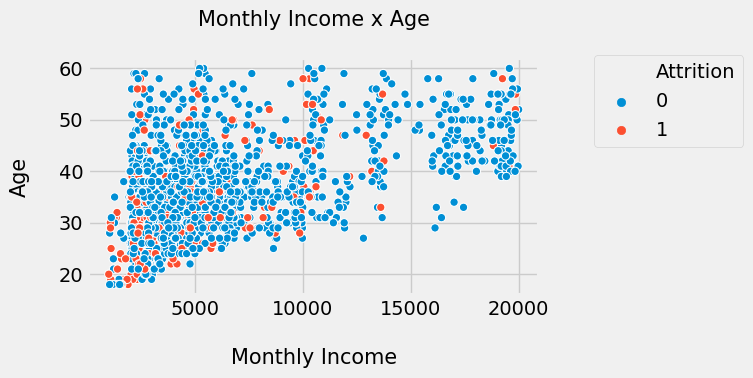

In [9]:
plt.clf()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
font_opts = {"fontsize":20, "fontweight":"bold"}

#####################################################
#####################################################

ax = sns.scatterplot(x="MonthlyIncome", y="Age", hue="Attrition", data=df)
plt.title("Monthly Income x Age\n", fontsize=15)
plt.xlabel("\nMonthly Income", fontsize=15)
plt.ylabel("Age\n", fontsize=15)

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()
plt.plot();

In [10]:
print("Total Attrition: {}".format(df["Attrition"].sum()))
print("Total Stock Option 0: {}".format(df.loc[df["StockOptionLevel"] == 0]["Attrition"].count()))
print("Turnover Stock Option 0: {}".format(df.loc[df["StockOptionLevel"] == 0]["Attrition"].sum()))
print("Max Companies Worked == 1: {}".format(df.loc[df["NumCompaniesWorked"] <= 1]["Attrition"].sum()))
print("More than 4 years without a promotion: {}".format(df.loc[df["YearsSinceLastPromotion"] > 4]["Attrition"].sum()))
print("Total Job Level == 1: {}".format(df.loc[df["JobLevel"] == 1]["Attrition"].sum()))
print("Total Overtime: {}".format(df.loc[df["OverTime"] == 1]["Attrition"].sum()))

Total Attrition: 237
Total Stock Option 0: 631
Turnover Stock Option 0: 154
Max Companies Worked == 1: 121
More than 4 years without a promotion: 37
Total Job Level == 1: 143
Total Overtime: 127


No período de criação do dataset, 237 funcionários sairam da empresa (16% de turnover).<br>
Desses 237 funcionários...
- 51% havia trabalhado em no máximo até 1 empresa
- 53% faziam hora extra
- 65% não tinham opções de ação
- 60% estavam no nível 1
- 16% não eram promovidos a mais de 4 anos<br><br>

Parece que a baixa remuneração e a falta de benefícios (sem ação) é um forte motivador para a saída dos funcionários (comum nos mais jovens).

# Deep Dive

- Satisfação
- Renda Mensal

## Esses funcionários estão satisfeitos com a empresa?

<Figure size 640x480 with 0 Axes>

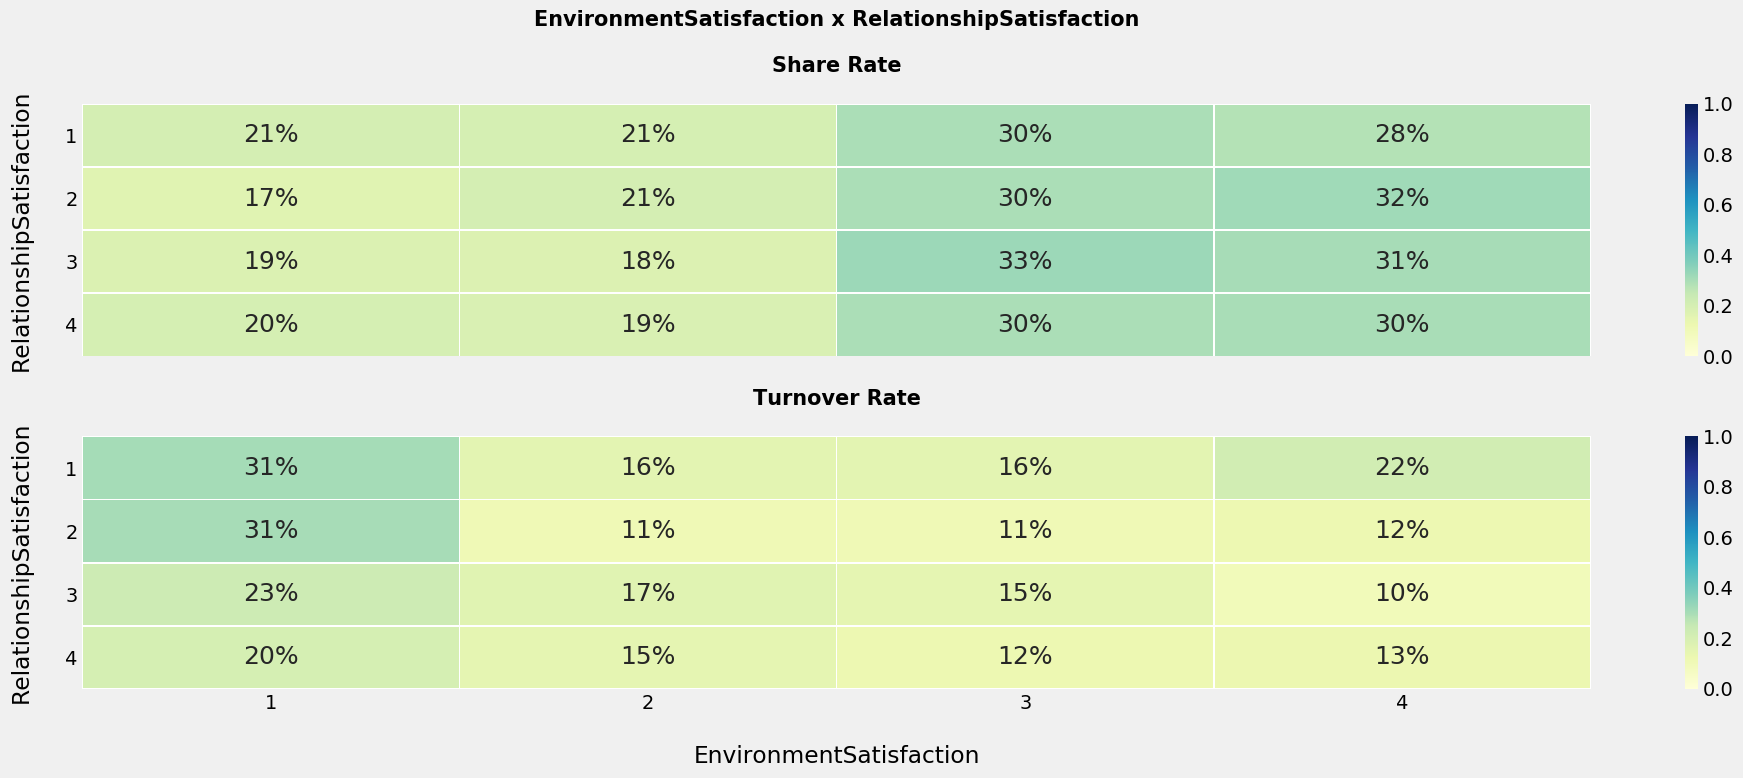

In [11]:
plot_cohort(df, "EnvironmentSatisfaction", "RelationshipSatisfaction")

Funcionários insatisfeitos com o ambiente e com as relações de trabalho parecem ser um grupo de risco. Exploremos isso mais a fundo.<br>

Temos 5 features que avaliam o nível de satisfação do funcionário numa escala de 1 a 4, onde as notas 3 e 4 são positivas.<br>
Vamos combiná-las para tentar criar uma nota de satisfação do funcionário em geral.<br>

In [12]:
df["EmployeeOverallSatisfaction"] = (
    np.round((df["EnvironmentSatisfaction"] 
    + df["JobSatisfaction"] 
    + df["RelationshipSatisfaction"]
    + df["JobInvolvement"] 
    + df["WorkLifeBalance"]) / 5)
).astype(int)

<Figure size 640x480 with 0 Axes>

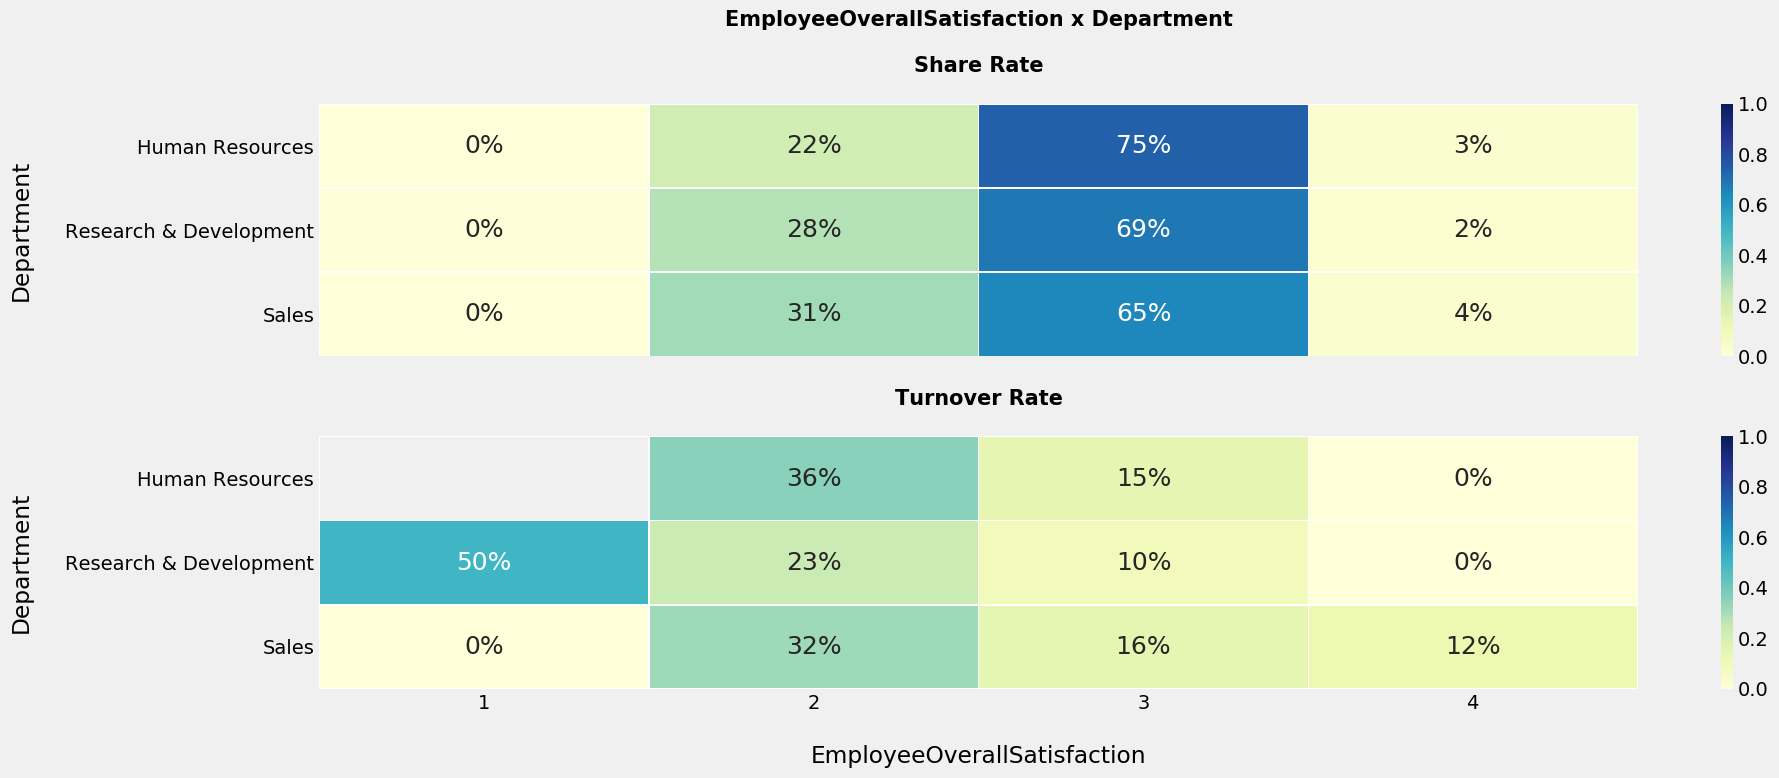

In [13]:
plot_cohort(df, "EmployeeOverallSatisfaction", "Department")

A taxa de turnover parece diminuir a medida que o nível de satisfação aumenta.

Na área de **Customer Experience (CX)**, uma das métricas utilizadas para mensurar o nível de satisfação do cliente ao produto, empresa ou serviço é o **Customer Satisfaction Score (CSAT)**. Esse score pode ser calculado dividindo a soma das avaliações positivas (notas 4 e 5) pelo número total de avaliações.<br>

Tentarei replicar esse conceito. Estou interessado em quais Departamentos e Jobs estão insatisfeitos (e como isso conversa com o attrition).

In [14]:
## Adicionando a coluna PositiveResponse
df.loc[df["EmployeeOverallSatisfaction"].isin([3,4]), 'PositiveResponse'] = 1
df.loc[~df["EmployeeOverallSatisfaction"].isin([3,4]), 'PositiveResponse'] = 0

In [15]:
csat_per_department = (
    df
    .groupby(["Department"])
    .agg(
        Churned=("Attrition", "sum"),
        Count=("Attrition", "count"),
        PositiveResponse=("PositiveResponse", "sum"),
        AvgMonthlyIncome=("MonthlyIncome", "mean"),
        MedianMonthlyIncome=("MonthlyIncome", np.median)
    )
)

csat_per_department["TurnOverRate"] = (csat_per_department["Churned"] * 100 / csat_per_department["Count"]).astype(int)
csat_per_department["CSAT"] = (csat_per_department["PositiveResponse"] * 100 / csat_per_department["Count"]).astype(int)
csat_per_department

,Churned,Count,PositiveResponse,AvgMonthlyIncome,MedianMonthlyIncome,TurnOverRate,CSAT
Department,,,,,,,
Human Resources,12,63,49.0,6654.508,3886.0,19,77
Research & Development,133,961,684.0,6281.253,4374.0,13,71
Sales,92,446,305.0,6959.173,5754.5,20,68


Os departamentos com CSAT mais baixos tiveram as maiores taxas de turnover.<br>
Como fica essa visão na quebra por Job Role?

In [16]:
csat_per_job = (
    df
    .groupby(["Department", "JobRole"])
    .agg(
        Churned=("Attrition", "sum"),
        Count=("Attrition", "count"),
        PositiveResponse=("PositiveResponse", "sum"),
        AvgMonthlyIncome=("MonthlyIncome", "mean"),
        MedianMonthlyIncome=("MonthlyIncome", np.median)
    )
)

csat_per_job["TurnOverRate"] = (csat_per_job["Churned"] * 100 / csat_per_job["Count"]).astype(int)
csat_per_job["CSAT"] = (csat_per_job["PositiveResponse"] * 100 / csat_per_job["Count"]).astype(int)
csat_per_job

Churned  Count  \
Department             JobRole                                     
Human Resources        Human Resources                 12     52   
                       Manager                          0     11   
Research & Development Healthcare Representative        9    131   
                       Laboratory Technician           62    259   
                       Manager                          3     54   
                       Manufacturing Director          10    145   
                       Research Director                2     80   
                       Research Scientist              47    292   
Sales                  Manager                          2     37   
                       Sales Executive                 57    326   
                       Sales Representative            33     83   

                                                  PositiveResponse  \
Department             JobRole                                       
Human Resources        Human Resources                        40.0   
                       Manager                                 9.0   
Research & Development Healthcare Representative              98.0   
                       Laboratory Technician                 176.0   
                       Manager                                43.0   
                       Manufacturing Director                108.0   
                       Research Director                      56.0   
                       Research Scientist                    203.0   
Sales                  Manager                                25.0   
                       Sales Executive                       220.0   
                       Sales Representative                   60.0   

                                                  AvgMonthlyIncome  \
Department             JobRole                                       
Human Resources        Human Resources                    4235.750   
                       Manager                           18088.636   
Research & Development Healthcare Representative          7528.763   
                       Laboratory Technician              3237.170   
                       Manager                           17130.333   
                       Manufacturing Director             7295.138   
                       Research Director                 16033.550   
                       Research Scientist                 3239.973   
Sales                  Manager                           16986.973   
                       Sales Executive                    6924.279   
                       Sales Representative               2626.000   

                                                  MedianMonthlyIncome  \
Department             JobRole                                          
Human Resources        Human Resources                         3093.0   
                       Manager                                18844.0   
Research & Development Healthcare Representative               6811.0   
                       Laboratory Technician                   2886.0   
                       Manager                                17545.5   
                       Manufacturing Director                  6447.0   
                       Research Director                      16510.0   
                       Research Scientist                      2887.5   
Sales                  Manager                                17048.0   
                       Sales Executive                         6231.0   
                       Sales Representative                    2579.0   

                                                  TurnOverRate  CSAT  
Department             JobRole                                        
Human Resources        Human Resources                      23    76  
                       Manager                               0    81  
Research & Development Healthcare Representative             6    74  
                       Laboratory Tech

Não parece existir correlação direta entre a taxa de turnover e o CSAT.<br>
Exploremos um pouco mais a fundo as principais posições 
**Adicionando a visão por JobRole...**<br>
Temos 5 posições em "grupos de risco" (alta de attrition):
- Sales Representative (39%)
- Laboratory Technician (23%)
- Human Resources (23%)
- Sales Executive (17%)
- Research Scientist (16%)

Desses 5, 80% possuí uma faixa salarial relativamente baixa. Exceção de Sales Executive que possuí o CSAT mais baixo (67%).<br><br>

Olhemos para esses cargos mais a fundo.

## Distribuições salariais em cargos de "risco"

In [17]:
job_list = ["Sales Representative", "Laboratory Technician", "Human Resources", "Sales Executive", "Research Scientist"]

df_risc = df.copy()
df_risc = df_risc.loc[df_risc["JobRole"].isin(job_list)]

<Figure size 640x480 with 0 Axes>

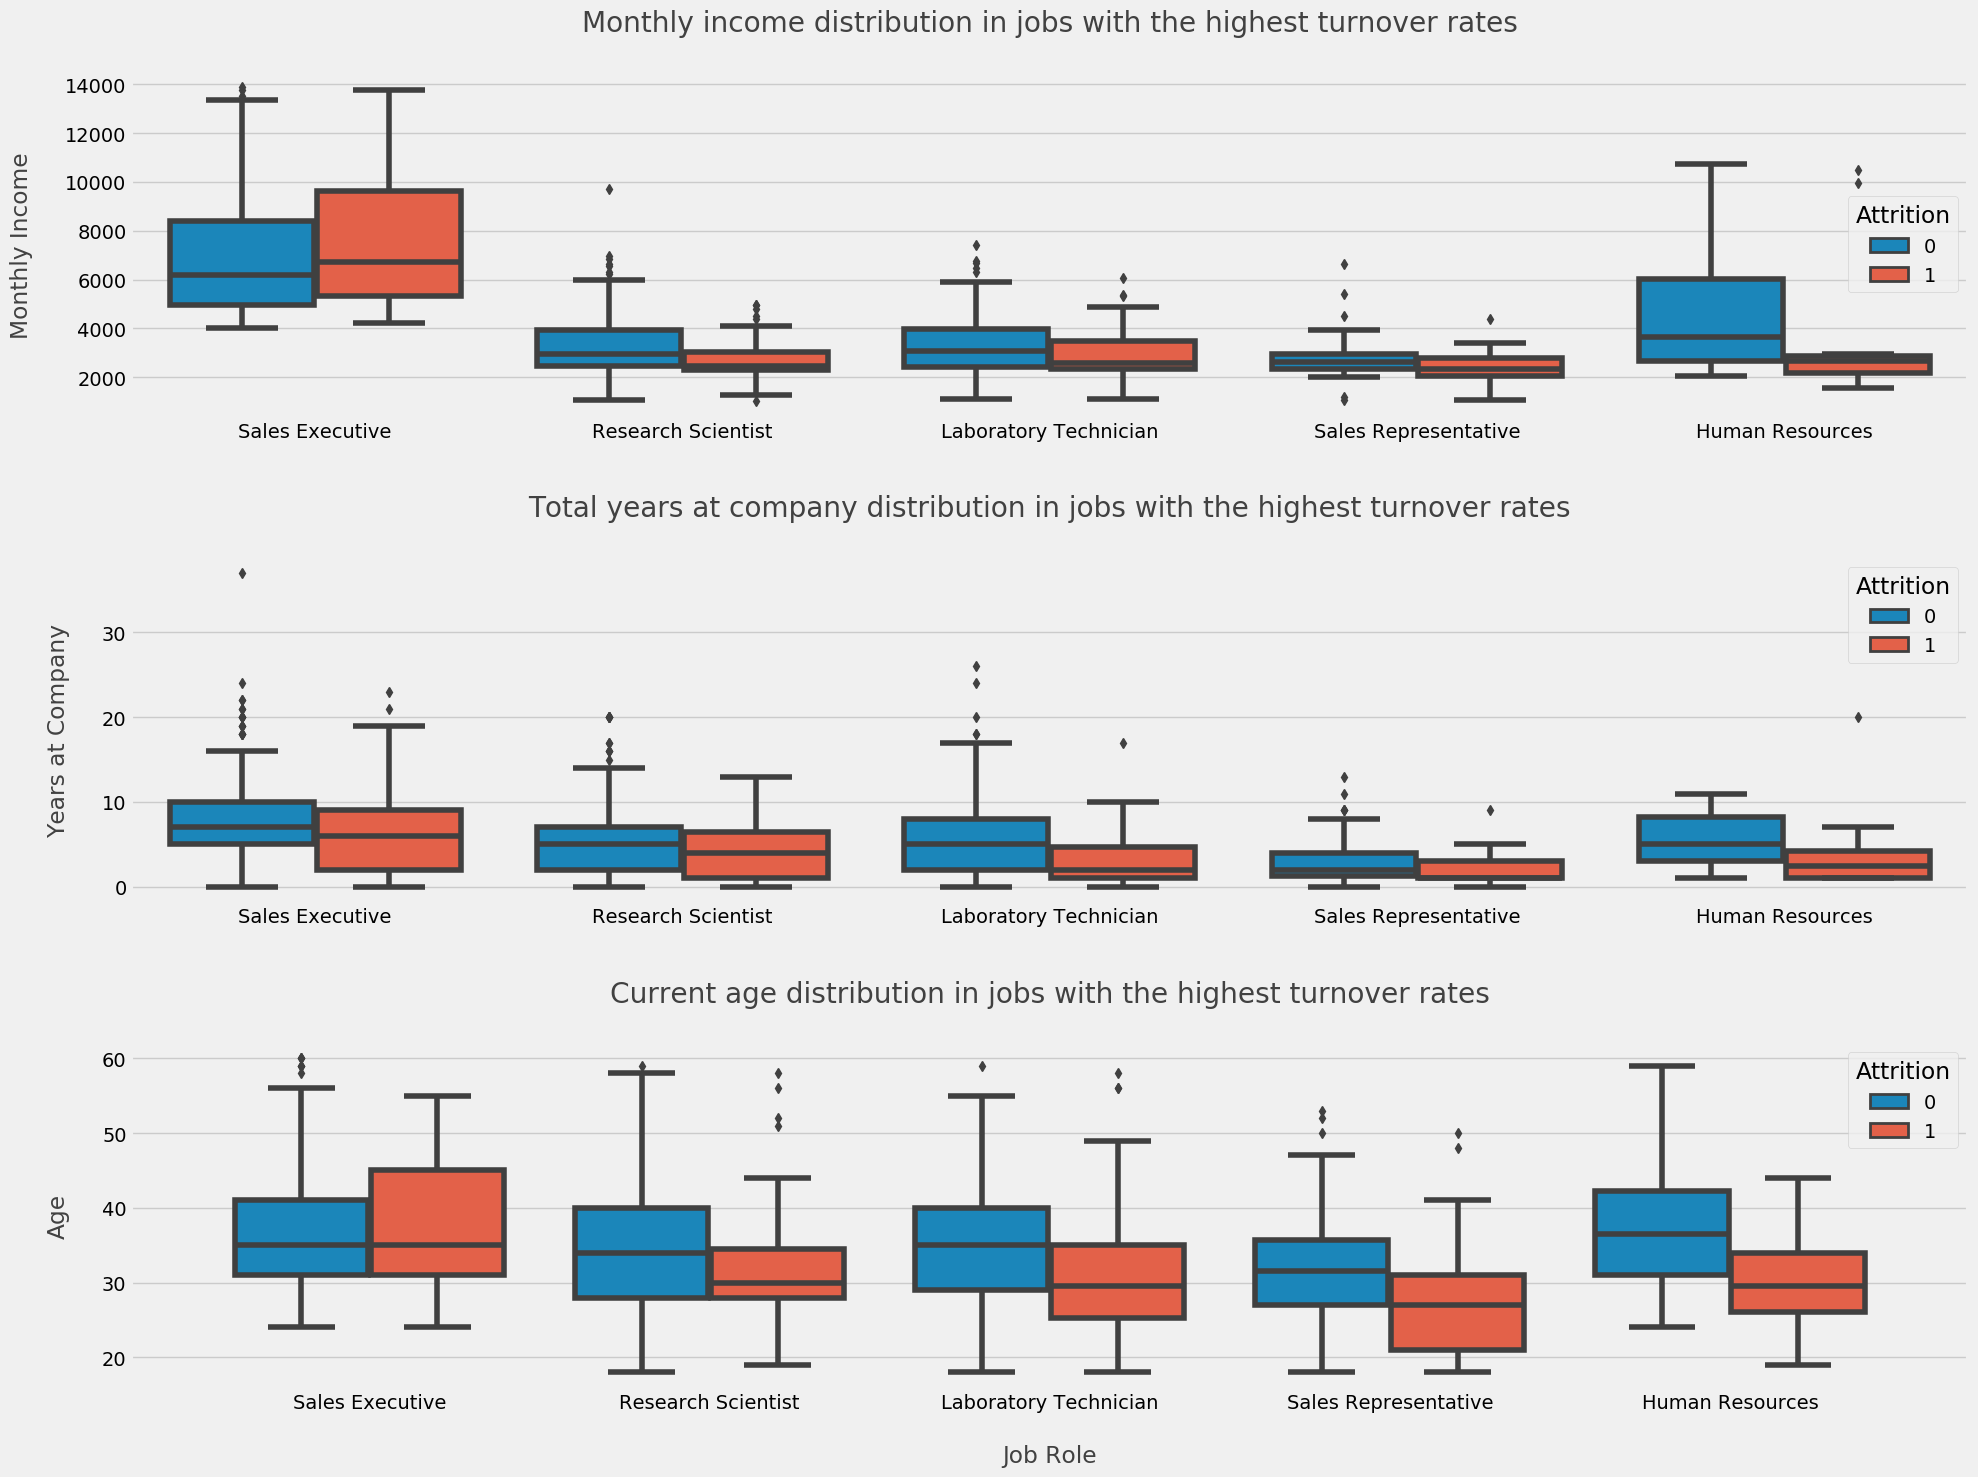

In [18]:
plt.clf()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,15))

#####################################################
#####################################################

plt.subplot(311)

ax = sns.boxplot(x="JobRole", y="MonthlyIncome", hue="Attrition", data=df_risc)
plt.title("Monthly income distribution in jobs with the highest turnover rates\n", color='#414141')
plt.xlabel("", color='#414141')
plt.ylabel("Monthly Income\n", color='#414141')

#####################################################
#####################################################

plt.subplot(312)

ax = sns.boxplot(x="JobRole", y="YearsAtCompany", hue="Attrition", data=df_risc)
plt.title("\nTotal years at company distribution in jobs with the highest turnover rates\n", color='#414141')
plt.xlabel("", color='#414141')
plt.ylabel("Years at Company\n", color='#414141')

#####################################################
#####################################################

plt.subplot(313)

ax = sns.boxplot(x="JobRole", y="Age", hue="Attrition", data=df_risc)
plt.title("\nCurrent age distribution in jobs with the highest turnover rates\n", color='#414141')
plt.xlabel("\nJob Role", color='#414141')
plt.ylabel("Age\n", color='#414141')


plt.tight_layout()
plt.plot();

As posições: Sales Representative, Laboratory Technician e Research Scientist e Human Resources<br>
São posições com baixo salário dentro da empresa. Eles representam 65% do total de attrition dentro da empresa.<br>

Em Sales Executive o motivo de saída não parece estar relacionada ao salário mensal, contudo foi o grupo com menor CSAT.<br>

## O salário baixo desses cargos tem relação com o nível de educação?

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 640x480 with 0 Axes>

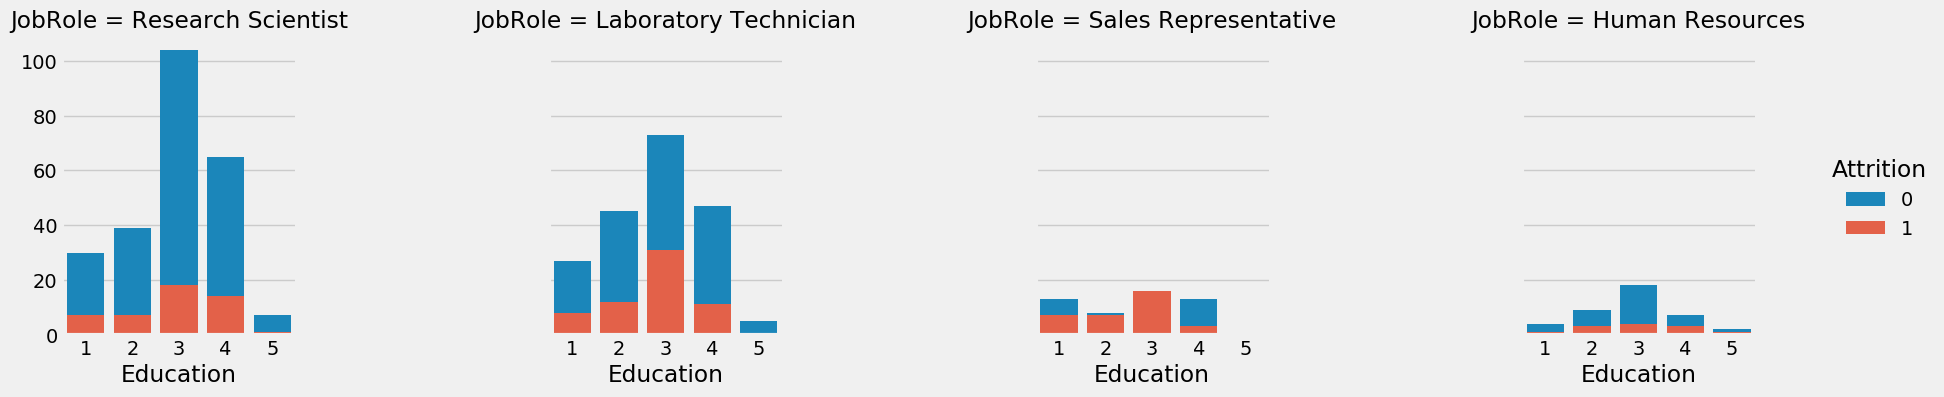

In [19]:
plt.clf()
plt.style.use('fivethirtyeight')

#####################################################
#####################################################

g = sns.FacetGrid(df_risc[~df_risc["JobRole"].isin(["Sales Executive"])], col="JobRole", hue="Attrition", col_wrap=4)
g = (g.map(sns.countplot, "Education").add_legend())
g.fig.set_size_inches(20,5)

<Figure size 640x480 with 0 Axes>

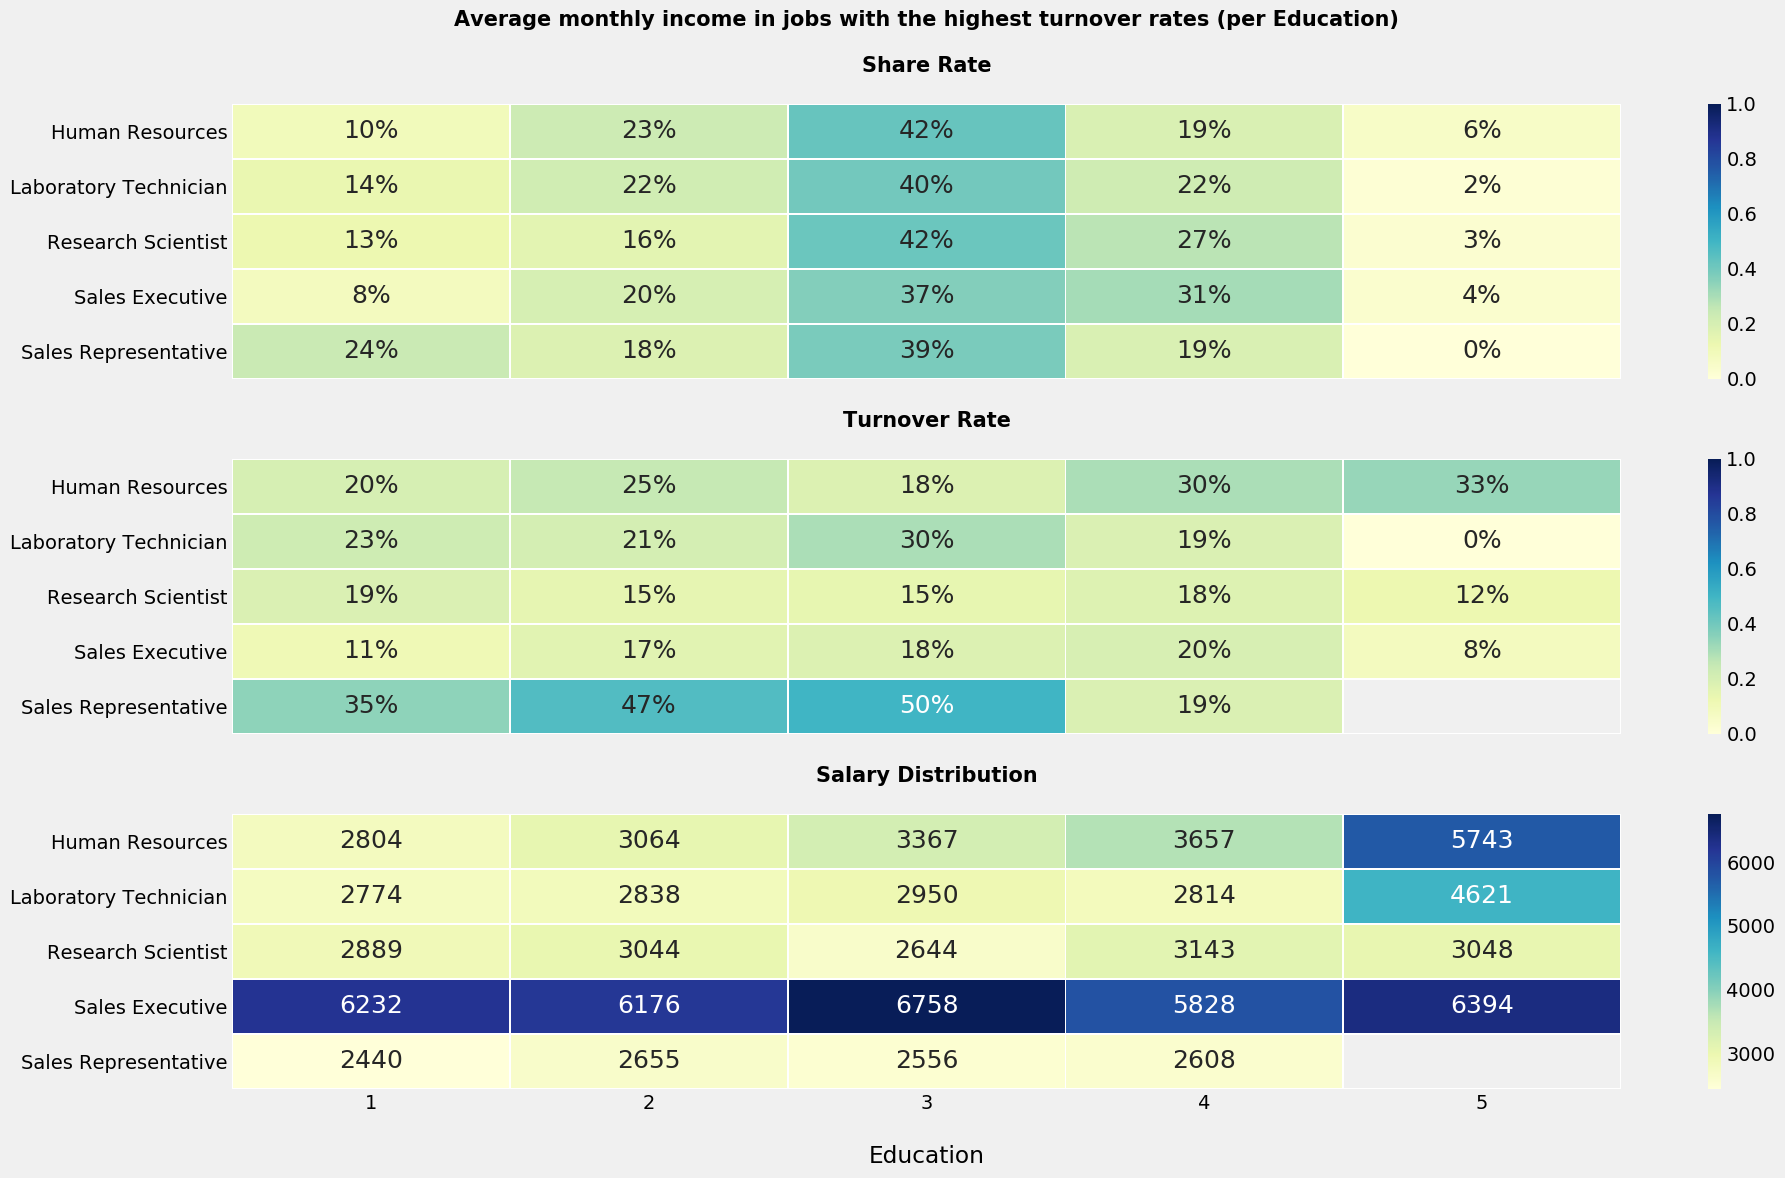

In [20]:
plot_heatmap(df_risc, "JobRole", "Education")

Não há uma variação aparente de salários por nível de educação. Será que isso não causa frustração interna?

## Existe perspectiva de crescimento dentro da empresa?

<Figure size 640x480 with 0 Axes>

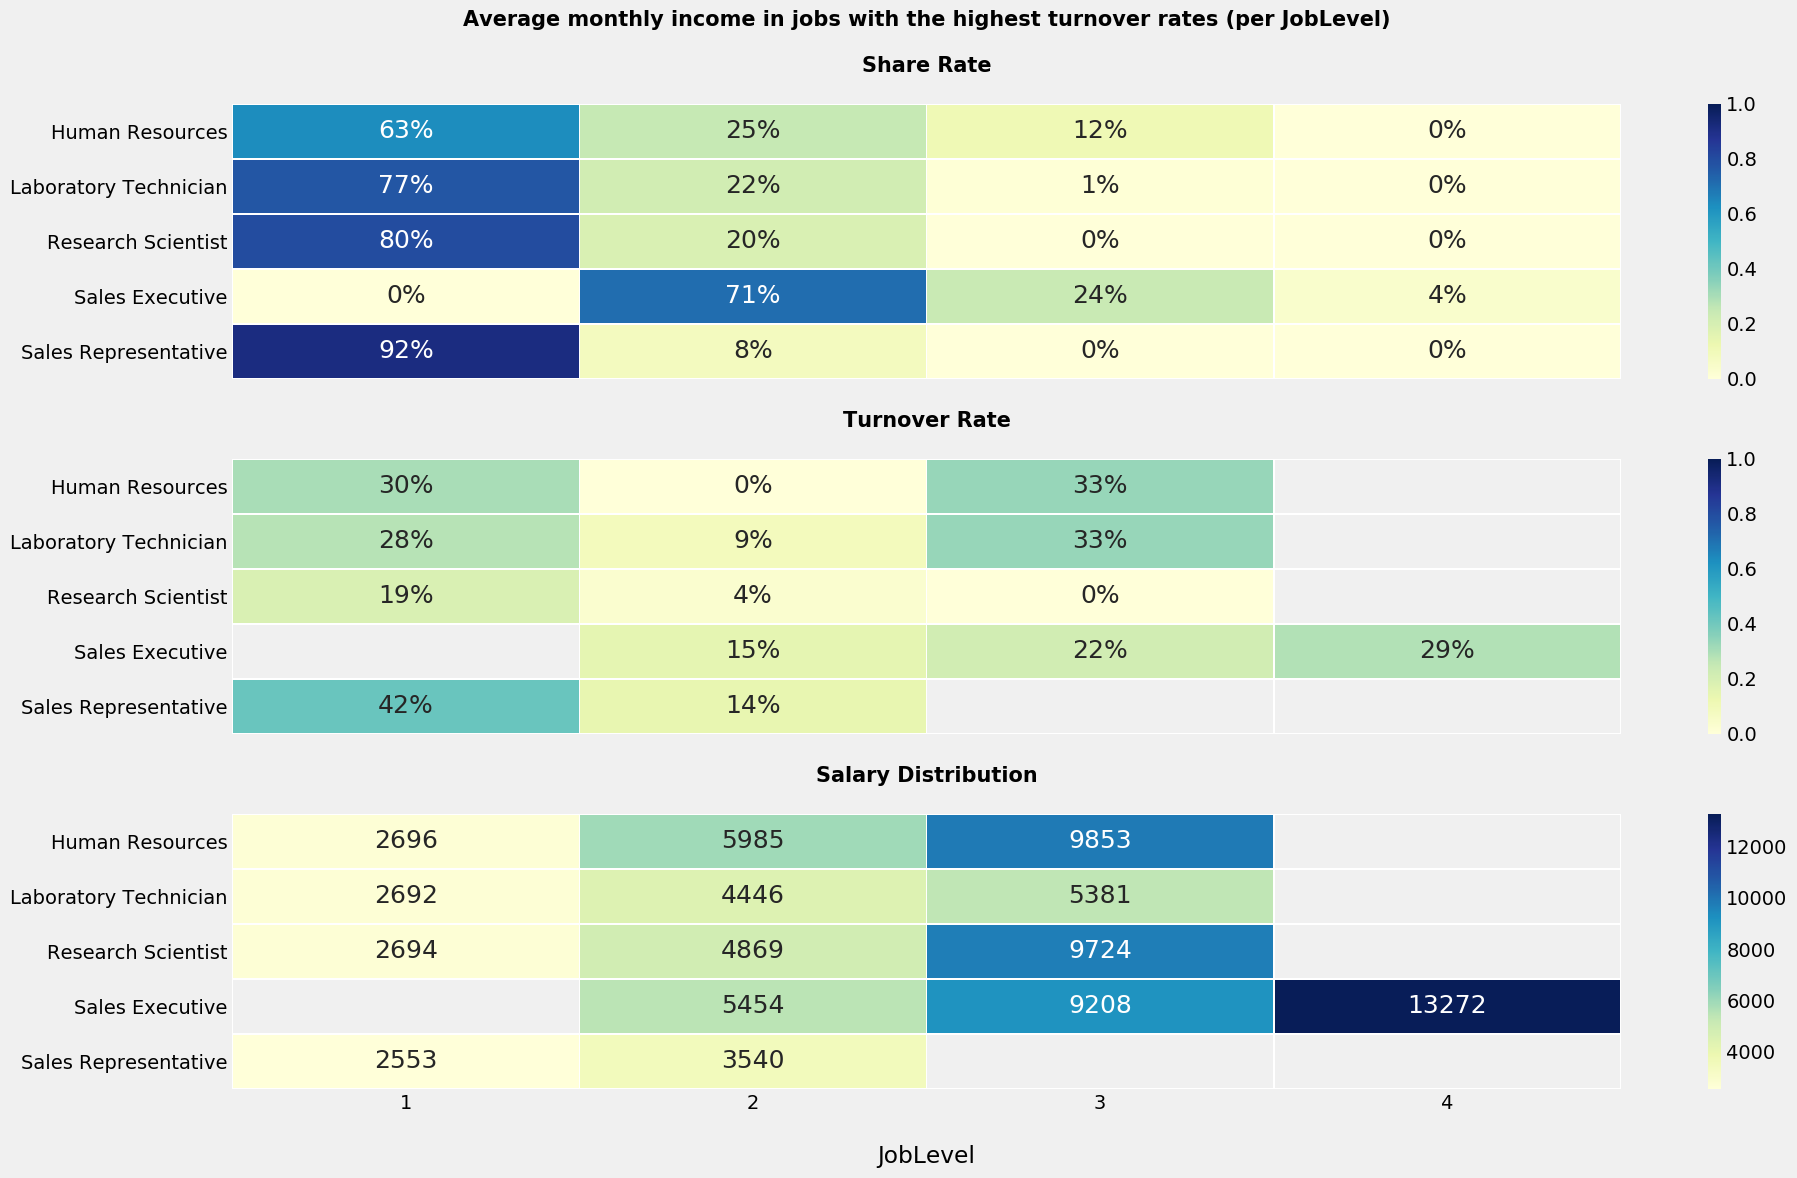

In [21]:
plot_heatmap(df_risc, "JobRole", "JobLevel")

Conseguimos tirar alguns insights interessantes do gráfico acima.<br>
Cargos mais alto pagam melhor.<br>
Sales Representative aparentemente vai apenas até o nível 2. A próxima promoção seria para o cargo de Sales Executive?<br>

Além disso, vemos que:
- Funcionários são na maioria do nível 1
- A rotatividade dos cargos Human Resources e Sales Executive é maior nos níveis 3 e 4. A motivação da saída não parece ser salarial. **Existe algum problema com a liderança da empresa? Como está o nível de satisfação deles?**
- Sales Representative recebem o menor aumento percentual do grupo ao subir de cargo. 50% dos que sairam faziam hora extra

# Conclusão

Essa é uma análise inicial. Os funcionários foram tratados com igualdade e não com equidade. Em uma análise mais profunda seria importante considerar avaliações passadas, tempo de experiência, genêro, etc para entender se os salários atuais estão condizentes com os cargos atuais.

Uma reestruturação salarial parece uma quick win para diminuição total de attrition. Antes porém, um melhor entendimento da compatibilidade salarial atual com o mercado se mostra necesário.